In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

# Convolutional Neural Networks

ConvNets are particularly well suited for data that has a spatial component to it. Things like images, audio, and text. Load the provided MNIST dataset from Tensorflow, split into training and test, and then display a few examples.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)


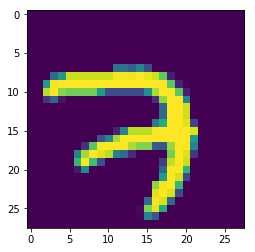

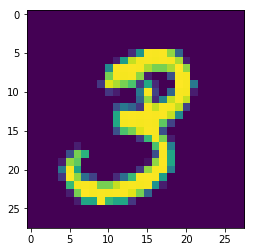

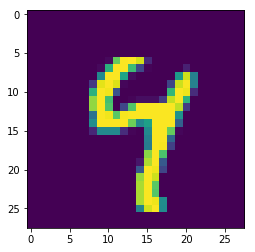

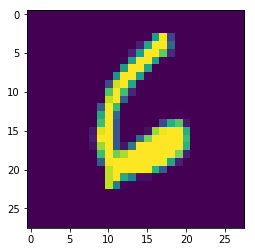

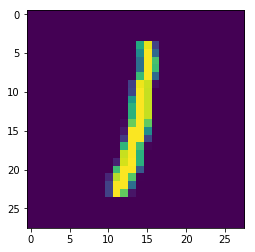

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

X_train = np.reshape(mnist.train.images, (-1, 28, 28, 1))
y_train = np.asarray(mnist.train.labels, dtype=np.int32)

X_test = np.reshape(mnist.test.images, (-1, 28, 28, 1))
y_test = np.asarray(mnist.test.labels, dtype=np.int32)

print(X_train.shape)

for i in range(5):
    plt.imshow(X_train[i].squeeze())
    plt.show()

Again, we will need placeholders for our batches when we use minibatch gradient descent.

In [3]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='X')
    
with tf.name_scope('targets_placeholder'):
    y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

Set up our NN hyperparameters

In [4]:
LR = 0.001
EPOCHS = 15
BATCHSIZE = 32

Much like our vanailly neural network example, we will create generic layer functions that take certain values as parameters. These functions will allow us to quickly and easily set up our Convolutional neural network with little redudancy. They will also allow us to rapidly prototype different architectures, if we wanted more or less layers in any region of the network

In [5]:
def conv_layer(X, in_dims, n_kernels, kernel_size, name, activation=None):
    '''
    Sets up a convolutional layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    in_dims: number of channels incoming to this layer
    n_kernels: number of convolutional kernels to use in the layer
    kernel_size: the size of each kernel as (kernel_size, kernel_size)
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        init = tf.truncated_normal([kernel_size, kernel_size, in_dims, n_kernels], stddev=0.1)
        W = tf.Variable(init, name='kernel_weights_{}'.format(name))
        b = tf.Variable(tf.constant(0.1, shape=[n_kernels]))
        conv = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME') + b
        if activation is not None:
            return activation(conv)
        else:
            return conv
        
def max_pool(X, pool_size, name):
    '''
    Sets up a pooling layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    pool_size: the window size for the maxpool operation in (pool_size, pool_size)
    name: the name of the scope to be used with this layer

    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        return tf.nn.max_pool(X, ksize=[1, pool_size, pool_size, 1], 
                              strides=[1, pool_size, pool_size, 1], padding='SAME')
        
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
def output_layer(X, n_units, name):
    '''
    Same as dense layer but doesn't take an activation
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        logits = tf.add(tf.matmul(X, W), b, name='logits_{}'.format(name))
        
    return logits

# Exercise

Build a convolutional neural network using the layer definitions that we created above. Try to come up with an architecture to maximize test set accuracy.

### Solution

In [6]:
# build the network
with tf.name_scope('cnn'):
    conv_1 = conv_layer(X, in_dims=1, n_kernels=8, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = conv_layer(pool_1, in_dims=8, n_kernels=16, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = max_pool(conv_2, pool_size=2, name='pool_b')
    
    flat = tf.reshape(pool_2, [-1, 7*7*16])
    
    dense = dense_layer(flat, 32, name='dense_layer', activation=tf.nn.relu)
    y_logits = output_layer(dense, 10, name='output')

Set up our loss and training algorithms. We'll use `Adam` here, which is a tweak on the way that stochastic gradient descent works.

In [7]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_logits))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(LR, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('accuracy'):
    corrects = tf.equal(tf.argmax(tf.nn.softmax(y_logits),1), tf.argmax(y_test, 1))
    acc = tf.reduce_mean(tf.cast(corrects, tf.float32))

Train our network, using essentially the same methodology as the other notebooks. 

In [12]:
#saver = tf.train.Saver()
init = tf.global_variables_initializer()

losses = []
n_samples = X_train.shape[0]
with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        if e % 5 == 0:
            print("Epoch:", e, 
                  "Current loss:", 
                  sess.run(loss, feed_dict={X: X_train, y: y_train}), 
                  "Test loss:",
                  sess.run(loss, feed_dict={X: X_test, y: y_test}),
                  "Test Accuracy:",
                  sess.run(acc, feed_dict={X: X_test, y: y_test}))
            
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]
            sess.run(train_step, feed_dict={X: X_b, y: y_b})
            losses.append(sess.run(loss, feed_dict={X: X_b, y: y_b}))

    # We use a built-in TF helper to export variables to constants
    output_node_name = 'cnn/output/logits_output'
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        output_node_name.split(",") # The output node names are used to select the usefull nodes
    ) 

    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile('./saved_model/cnn_mnist.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())

Epoch: 0 Current loss: 2.53521 Test loss: 2.53242 Test Accuracy: 0.0993
0 input_placeholder/X
1 targets_placeholder/y
2 cnn/conv_a/truncated_normal/shape
3 cnn/conv_a/truncated_normal/mean
4 cnn/conv_a/truncated_normal/stddev
5 cnn/conv_a/truncated_normal/TruncatedNormal
6 cnn/conv_a/truncated_normal/mul
7 cnn/conv_a/truncated_normal
8 cnn/conv_a/kernel_weights_conv_a
9 cnn/conv_a/kernel_weights_conv_a/Assign
10 cnn/conv_a/kernel_weights_conv_a/read
11 cnn/conv_a/Const
12 cnn/conv_a/Variable
13 cnn/conv_a/Variable/Assign
14 cnn/conv_a/Variable/read
15 cnn/conv_a/Conv2D
16 cnn/conv_a/add
17 cnn/conv_a/Relu
18 cnn/pool_a/MaxPool
19 cnn/conv_b/truncated_normal/shape
20 cnn/conv_b/truncated_normal/mean
21 cnn/conv_b/truncated_normal/stddev
22 cnn/conv_b/truncated_normal/TruncatedNormal
23 cnn/conv_b/truncated_normal/mul
24 cnn/conv_b/truncated_normal
25 cnn/conv_b/kernel_weights_conv_b
26 cnn/conv_b/kernel_weights_conv_b/Assign
27 cnn/conv_b/kernel_weights_conv_b/read
28 cnn/conv_b/Const
2

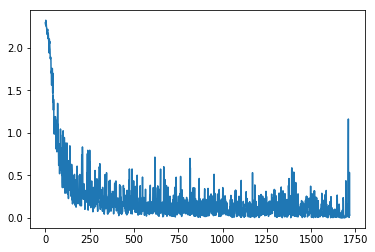

In [9]:
plt.plot(np.array(losses))
plt.show()

Collect the predictions for the test set.

In [10]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, './saved_model/cnn_mnist.ckpt')
    preds = sess.run(tf.nn.softmax(y_logits), feed_dict={X: X_test})
    pred_val = tf.argmax(preds, 1).eval()

NameError: name 'saver' is not defined

Display some of the images and their predicted values.

In [ ]:
for j in range(5):
    plt.imshow(X_test[j].squeeze())
    plt.title('Predicted: {}'.format(pred_val[j]))
    plt.show()